In [213]:
import pandas as pd
import numpy as np
import pycountry
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import ScalarFormatter
from PIL import Image
import os
import seaborn as sns
from matplotlib.patheffects import withStroke
import matplotlib as mpl
from adjustText import adjust_text
import matplotlib.patheffects as pe



In [214]:
ads_data_aff = pd.read_parquet('all_data_country_clean.parquet')

In [215]:
country_population_resarchers = pd.read_csv('country_population_researchers.csv')
country_population_resarchers['num_researchers'] = country_population_resarchers['Latest_Researchers_per_Million'] * (country_population_resarchers['2023_population'] / 1_000_000)
country_population_resarchers_over_1000 = country_population_resarchers[country_population_resarchers['num_researchers'] > 3000].sort_values(by='num_researchers', ascending=False)
country_population_resarchers_over_1000.shape

(97, 30)

In [216]:
def get_mean_population_per_year(pop_df):
    # Select only year columns (2000–2023)
    year_cols = [str(y) for y in range(2000, 2024)]

    # Melt the wide format into long format
    pop_long = pop_df.melt(
        value_vars=year_cols,
        var_name='year',
        value_name='population'
    )

    # Convert year to integer
    pop_long['year'] = pop_long['year'].astype(int)

    # Group by year and compute mean
    mean_pop_per_year = (
        pop_long.groupby('year')['population']
        .mean()
        .reset_index(name='mean_population')
    )

    return mean_pop_per_year

In [217]:
def get_country_article_stats(
    df,
    country_col='first_author_aff_country_final_valid',
    group_by_year=False,
    group_by_pub=False,
    filter_col=None,
    keyword=None,
    country_stats=None,
    include_eu=True
    ):

    # Manual ISO mapping
    manual_map = {
        "Türkiye": "tr", "Turkey": "tr",
        "Russian Federation": "ru", "Russia": "ru",
        "USA": "us", "United States": "us",
        "UK": "gb", "United Kingdom": "gb",
        "South Korea": "kr", "Korea, Republic of": "kr",
        "North Korea": "kp", "Korea, Democratic People's Republic of": "kp",
        "Iran": "ir", "Iran, Islamic Republic of": "ir",
        "Taiwan": "tw", "Taiwan, Province of China": "tw",
        "European Union": "eu",
    }

    eu_countries = {
        "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Czech Republic",
        "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary",
        "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands",
        "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
    }

    def get_country_code(name):
        name = name.strip()
        if name in manual_map:
            return manual_map[name]
        try:
            return pycountry.countries.lookup(name).alpha_2.lower()
        except LookupError:
            return None

    # Filter if needed
    if filter_col and keyword:
        df = df[df[filter_col].str.contains(keyword, case=False, na=False)]

    # Define grouping
    group_keys = [country_col]
    if group_by_year:
        group_keys.append('year')
    if group_by_pub:
        group_keys.append('pub')

    # Group and count
    grouped = df.groupby(group_keys).size().reset_index(name='article_count')
    grouped = grouped.rename(columns={country_col: 'country'})
    grouped['country_code'] = grouped['country'].apply(get_country_code)

    # Merge population stats
    if country_stats is not None:
        stats = country_stats.rename(columns={
            'Country Name': 'country',
            '2023_population': 'population',
            'Latest_Researchers_per_Million': 'researchers_per_million'
        })
        grouped = grouped.merge(stats[['country', 'population', 'researchers_per_million']], on='country', how='left')

        grouped['per_million_people'] = grouped['article_count'] / (grouped['population'] / 1_000_000)
        grouped['num_researchers'] = grouped['researchers_per_million'] * (grouped['population'] / 1_000_000)
        grouped['per_1k_researchers'] = grouped['article_count'] / (grouped['num_researchers'] / 1_000)
    else:
        grouped['per_million_people'] = None
        grouped['per_1k_researchers'] = None

    # --- Add EU manually ---
    if include_eu and country_stats is not None:
        eu_mask = grouped['country'].isin(eu_countries)
        eu_group = grouped[eu_mask]

        group_cols = []
        if group_by_year:
            group_cols.append('year')
        if group_by_pub:
            group_cols.append('pub')

        if not eu_group.empty:
            # Drop rows with missing population or researchers
            valid_eu_group = eu_group.dropna(subset=['population', 'researchers_per_million'])

            if not valid_eu_group.empty:
                if group_cols:
                    # Grouped mode (e.g. per year or per pub)
                    def compute_eu_stats(subgroup):
                        total_articles = subgroup['article_count'].sum()
                        total_population = subgroup['population'].sum()
                        if total_population == 0:
                            return pd.Series({
                                'article_count': total_articles,
                                'per_million_people': None,
                                'per_1k_researchers': None
                            })

                        weighted_rpm = (
                            (subgroup['researchers_per_million'] * subgroup['population']).sum() / total_population
                        )
                        num_researchers = weighted_rpm * (total_population / 1_000_000)

                        return pd.Series({
                            'article_count': total_articles,
                            'per_million_people': total_articles / (total_population / 1_000_000),
                            'per_1k_researchers': total_articles / (num_researchers / 1_000)
                        })

                    eu_summary = valid_eu_group.groupby(group_cols).apply(compute_eu_stats).reset_index()
                else:
                    # Single overall EU row
                    total_articles = valid_eu_group['article_count'].sum()
                    total_population = valid_eu_group['population'].sum()

                    weighted_rpm = (
                        (valid_eu_group['researchers_per_million'] * valid_eu_group['population']).sum() / total_population
                    )
                    num_researchers = weighted_rpm * (total_population / 1_000_000)

                    eu_summary = pd.DataFrame([{
                        'article_count': total_articles,
                        'per_million_people': total_articles / (total_population / 1_000_000),
                        'per_1k_researchers': total_articles / (num_researchers / 1_000)
                    }])

                eu_summary['country'] = 'European Union'
                eu_summary['country_code'] = 'eu'

                # Reorder columns to match grouped
                grouped = pd.concat([grouped, eu_summary], ignore_index=True)



    # Final columns
    cols = ['country', 'country_code', 'article_count', 'per_million_people', 'per_1k_researchers']
    return grouped[cols + [col for col in grouped.columns if col not in cols]]


In [218]:
df_counts =  get_country_article_stats(
    ads_data_aff,
    group_by_year=True,
    group_by_pub =True,
    country_stats=country_population_resarchers,
    include_eu=True
)

df_counts

C:\Users\adbva\AppData\Local\Temp\ipykernel_18732\1400521257.py:112: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,country,country_code,article_count,per_million_people,per_1k_researchers,year,pub,population,researchers_per_million,num_researchers
0,Afghanistan,af,1.0,0.024123,NaN,2021,Heliyon,41454761.0,NaN,NaN
1,Afghanistan,af,1.0,0.024123,NaN,2021,Remote Sensing Applications: Society and Envir...,41454761.0,NaN,NaN
2,Afghanistan,af,1.0,0.024123,NaN,2022,Stochastic Environmental Research and Risk Ass...,41454761.0,NaN,NaN
3,Afghanistan,af,1.0,0.024123,NaN,2024,Acta Geophysica,41454761.0,NaN,NaN
4,Afghanistan,af,1.0,0.024123,NaN,2024,Discover Geoscience,41454761.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
137714,European Union,eu,8.0,0.035335,0.008727,2025,npj Computational Mathematics,NaN,NaN,NaN
137715,European Union,eu,1.0,0.094534,0.025380,2025,npj Ocean Sustainability,NaN,NaN,NaN
137716,European Union,eu,2.0,0.033902,0.016240,2025,npj Quantum Information,NaN,NaN,NaN
137717,European Union,eu,1.0,0.012008,0.002537,2025,npj Scientific of Learning,NaN,NaN,NaN


In [219]:
def plot_country_bar_chart_with_flags(
    data,
    value_col='article_count',
    top_n=30,
    title=None,
    xlabel=None,
    filename=None,
    flag_dir='flags',
    figsize=(12, 9),
    zoom=0.3,
    use_log=False
    ):
    
    # --- Prep ---
    plot_data = data.copy().sort_values(by=value_col, ascending=False).head(top_n)
    countries = plot_data['country'].tolist()
    values = plot_data[value_col].tolist()
    rounded_values = [int(round(v)) if pd.notnull(v) else None for v in values]

    # Default labels
    if not title:
        title = f"Top {top_n} Countries by {value_col.replace('_', ' ').title()}"
    if not xlabel:
        xlabel = f"Publications {value_col.replace('_', ' ').title()}"
    if not filename:
        filename = f"figures/top_countries_by_{value_col}.png"

    # --- Plot ---
    plt.style.use("default")
    fig, ax = plt.subplots(figsize=figsize)

    # Full empty bars
    ax.barh(
        countries,
        [max(values)] * len(countries),
        edgecolor='#bbb',
        facecolor='none',
        linewidth=1,
        alpha=0.5,
    )

    # Filled bars
    bars = ax.barh(
        countries,
        values,
        color=['#614051'] * len(countries)
    )

    # X scale
    if use_log:
        ax.set_xscale('log')
        formatter = ScalarFormatter(useMathText=False)
        formatter.set_scientific(False)
        formatter.set_useOffset(False)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_xlim(left=max(1, min(values)) * 0.8, right=max(values) * 1.3)
    else:
        ax.set_xlim(left=0, right=max(values) * 1.05)

    # Labels & grid
    fig.text(-0.03, 0.91, title, ha='left', fontsize=13, weight='bold')
    fig.text(0.9, 0.915, "Data Source: SAO/NASA Astrophysics Data System (ADS)", 
         ha='right', fontsize=9, color='gray')
    
    ax.set_xlabel(xlabel, fontsize=14, weight='bold')
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_ylim(-0.5, len(countries) - 0.5)

    # Add flags & country names
    for i, row in plot_data.iterrows():
        idx = plot_data.index.get_loc(i)
        y_axes = (len(countries) - idx - 0.5) / len(countries)

        # Country name
        ax.text(-0.05, y_axes, row['country'], transform=ax.transAxes,
                va='center', ha='right', fontsize=12, color='black')

        # Flag
        code = row.get('country_code')
        if code:
            flag_path = os.path.join(flag_dir, f"{code}.png")
            if os.path.exists(flag_path):
                img = OffsetImage(Image.open(flag_path).convert("RGBA"), zoom=zoom)
                ab = AnnotationBbox(
                    img, (0.03, y_axes), xycoords='axes fraction',
                    boxcoords="offset points", frameon=False, pad=0,
                    xybox=(-25, 0), box_alignment=(1, 0.5)
                )
                ax.add_artist(ab)

    # Value labels on bars
    for bar, val in zip(bars, rounded_values):
        if val is not None:
            ax.text(val * 0.8 if not use_log else val * 0.81,
                    bar.get_y() + bar.get_height() / 2,
                    f"{val:,}", va='center', ha='left', fontsize=7,
                    color='white' if not use_log else 'white', weight='bold')

    # Rank labels
    if use_log:
        right_pos = 10 ** (np.log10(max(values)) + 0.095)
    else:
        right_pos = max(values) * 1.04

    for i, bar in enumerate(bars):
        ax.text(right_pos, bar.get_y() + bar.get_height() / 2,
                f"#{i+1}", va='center', ha='right', fontsize=10, color='gray')

    ax.invert_yaxis()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()


### For all journals

In [220]:
# Get the precomputed stats
df_stats = get_country_article_stats(
    ads_data_aff,
    group_by_year=False,
    country_stats=country_population_resarchers_over_1000,
    include_eu=True
)

# Plot raw counts
plot_country_bar_chart_with_flags(df_stats, xlabel = 'Number of Publications', title = 'Top Countries by Number of Publications (2000-2025)', filename = "figures/top_countries.png", value_col='article_count', use_log=True)

# Plot normalized by population
plot_country_bar_chart_with_flags(df_stats, xlabel = 'Number of Publications', title = 'Top Publishing Countries per 1M People (2000-2025)', filename = "figures/top_countries_per_million.png", value_col='per_million_people')

# Plot normalized by researchers
plot_country_bar_chart_with_flags(df_stats, xlabel = 'Number of Publications', title = 'Top Publishing Countries per 1K Researcher (2000-2025)', filename = "figures/top_countries_per_researcher.png",  value_col='per_1k_researchers')


### For Q1 journals

In [221]:
ads_data_aff_q1 = ads_data_aff[ads_data_aff['sjr_quartile'] == 'Q1']


# Get the precomputed stats
df_stats_q1 = get_country_article_stats(
    ads_data_aff_q1,
    group_by_year=False,
    country_stats=country_population_resarchers_over_1000,
    include_eu=True
)

# Plot raw counts
plot_country_bar_chart_with_flags(df_stats_q1, xlabel = 'Number of Publications', title = 'Top Countries by Number of Publications (SJR Q1 journals) (2000-2025)', filename = "figures/top_countries_q1.png", value_col='article_count', use_log=True)

# Plot normalized by population
plot_country_bar_chart_with_flags(df_stats_q1, xlabel = 'Number of Publications', title = 'Top Publishing Countries per 1M People (SJR Q1 journals) (2000-2025)', filename = "figures/top_countries_per_million_q1.png", value_col='per_million_people')

# Plot normalized by researchers
plot_country_bar_chart_with_flags(df_stats_q1, xlabel = 'Number of Publications', title = 'Top Publishing Countries per 1K Researcher (SJR Q1 journals) (2000-2025)', filename = "figures/top_countries_per_researcher_q1.png",  value_col='per_1k_researchers')


## Publications per year

In [222]:
def plot_top_countries_over_time(
    df,
    top_n=10,
    value_col='article_count',
    year_col='year',
    country_col='country',
    title='Top Countries by Number of Publications',
    figsize=(11, 7),
    color_palette='colorblind',
    filename = None,
    ):

    flag_colors = {
    "China": "#de2910",           # Red
    "United States": "#3c3b6e",   # Navy Blue
    "European Union": "#003399",  # EU blue
    "Germany": "#000000",         # Black (top stripe)
    "United Kingdom": "#012169",  # Deep blue
    "India": "#ff9933",           # Saffron (top stripe)
    "France": "#0055a4",          # Blue stripe
    "Russia": "#0033a0",          # Blue stripe
    "Japan": "#bc002d",           # Red circle
    "South Korea": "#003478",     # Blue
    "Italy": "#008c45",           # Green stripe
    # ...add more as needed
    }

    def get_flag_image(code, folder="flags", zoom=0.08):
        path = os.path.join(folder, f"{code}.png")
        if os.path.exists(path):
            img = Image.open(path).convert("RGBA")
            return OffsetImage(img, zoom=zoom)
        return None

    manual_map = {
        "USA": "us", "United States": "us",
        "UK": "gb", "United Kingdom": "gb",
        "South Korea": "kr", "Korea, Republic of": "kr",
        "Iran": "ir", "Iran, Islamic Republic of": "ir",
        "Taiwan": "tw", "Taiwan, Province of China": "tw",
        "European Union": "eu",  # manually added if needed
        # ... add any special cases
    }

    def get_country_code(name):
        name = name.strip()
        if name in manual_map:
            return manual_map[name]
        try:
            return pycountry.countries.lookup(name).alpha_2.lower()
        except LookupError:
            return None

    mean_pop_df = get_mean_population_per_year(country_population_resarchers)

    # Top countries
    top_countries = (
        df.groupby(country_col)[value_col]
        .sum()
        .sort_values(ascending=False)
        .head(top_n)
        .index.tolist()
    )

    # Pivot data
    subset = df[df[country_col].isin(top_countries)]
    pivot_df = subset.pivot(index=year_col, columns=country_col, values=value_col).fillna(0)
    pivot_df = pivot_df[top_countries]

    # Theme setup
    sns.set_theme(style='whitegrid')
    mpl.rcParams['axes.facecolor'] = '#e3f2fd'
    mpl.rcParams['axes.edgecolor'] = '#cccccc'
    mpl.rcParams['grid.color'] = '#dddddd'
    mpl.rcParams['font.family'] = 'DejaVu Sans'

    #colors = sns.color_palette(color_palette, n_colors=top_n)
    colors = [flag_colors[country] for country in pivot_df.columns]


    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('#f0f8ff')  # Optional

    mean_line, = ax.plot(
    mean_pop_df['year'],
    mean_pop_df['mean_population'] / 100000,
    linestyle='--',
    linewidth=2,
    color='black',
    marker='o',
    markersize=5,
    label='World Mean Population / 100K'  # <- add label here
    )

    for i, country in enumerate(pivot_df.columns):
        ax.plot(
            pivot_df.index,
            pivot_df[country],
            label=None,
            marker='o',
            linewidth=2.2,
            markersize=6,
            color=colors[i],
            path_effects=[
                pe.withStroke(linewidth=3.5, foreground='white')  # white outline
            ]
        )

    # Annotate mean population
    #ax.annotate("Mean Population",
    #            xy=(mean_pop_df['year'].max()-1, mean_pop_df['mean_population'].iloc[-1] / 100000),
    #            xytext=(-50, 5),
    #            textcoords='offset points',
    #            fontsize=10,
    #            color='black',
    #            #arrowprops=dict(arrowstyle='->', color='black')
    #            )
    
    # Annotate each country at the final point


    texts = []
    for i, country in enumerate(pivot_df.columns):
        last_year = pivot_df.index.max()-1
        last_value = pivot_df.loc[last_year, country]
        
        text = ax.text(
            last_year,
            last_value,
            country,
            fontsize=11,
            color=colors[i],
            ha='left',
            va='center',
            weight='bold',
            path_effects=[withStroke(linewidth=3, foreground='white')]
        )
        texts.append(text)

    adjust_text(texts, ax=ax, only_move={'text': 'y'}, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    """
    for i, country in enumerate(pivot_df.columns):
        y_vals = pivot_df[country]
        color = colors[i]
        code = get_country_code(country)

        # Plot the line without markers
        ax.plot(pivot_df.index, y_vals, linewidth=2, color=color)

        if code:
            img = get_flag_image(code, zoom=0.15)

            if img:
                for year, value in y_vals.items():
                    ab = AnnotationBbox(
                        img,
                        (year, value),
                        frameon=False,
                        box_alignment=(0.5, 0.5),
                        pad=0,
                        alpha = 0.01,
                    )
                    ax.add_artist(ab)
    """




    ax.annotate(
    "Data drop\n(incomplete year)",
    xy=(2025, 17000),         # Adjust Y if needed
    xytext=(20, -70),
    textcoords="offset points",
    fontsize=10,
    color='gray',
    rotation=-90,              # ✅ Correct usage
    ha='center',
    va='center',
    )


    # Labels & grid
    fig.text(0.01, 1.01, title, ha='left', fontsize=15, weight='bold')
    fig.text(0.99, 1.015, "Data Source: SAO/NASA Astrophysics Data System (ADS)", 
         ha='right', fontsize=9, color='gray')
    ax.set_xlabel("Year", fontsize=14, weight='bold')
    ax.set_ylabel("Number of Publications", fontsize=14, weight='bold')
    ax.tick_params(axis='both', labelsize=11, length=5)
    ax.grid(True, linestyle='--', axis='y', alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylim(0, pivot_df.max().max() * 1.05)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))

    # Remove top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legend inside upper left or outside
    ax.legend(
        title=None,
        fontsize=10,
        loc='upper left',
        frameon=True,
        framealpha=0.92,
        facecolor='white',
        edgecolor='gray'
    )
    ax.legend_.remove()
    ax.legend(["World Mean Population / 100K"], loc="upper left")

 

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()


In [223]:
# Get the precomputed stats
df_yearly = get_country_article_stats(
    ads_data_aff,
    group_by_year=True,
    country_stats=country_population_resarchers_over_1000,
    include_eu=True,
)

plot_top_countries_over_time(
    df_yearly,
    top_n=6,
    value_col='article_count',
    color_palette='Set2',
    filename = 'figures/top_countries_30_per_year_with_population.png'
)


C:\Users\adbva\AppData\Local\Temp\ipykernel_18732\1400521257.py:112: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [224]:
ads_data_aff_q1 = ads_data_aff[ads_data_aff['sjr_quartile'] == 'Q1']

df_yearly = get_country_article_stats(
    ads_data_aff_q1,
    group_by_year=True,
    country_stats=country_population_resarchers_over_1000,
    include_eu=True,
)

plot_top_countries_over_time(
    df_yearly,
    top_n=6,
    value_col='article_count',
    color_palette='Set2',
    title='Top Countries by Number of Publications (SJR Q1 journals)',
    filename = 'figures/top_countries_30_per_year_with_population_Q1.png'
)

C:\Users\adbva\AppData\Local\Temp\ipykernel_18732\1400521257.py:112: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [225]:
selected_countries = ['European Union', 'United States', 'China']
china_usa_eu = ads_data_aff[ads_data_aff['country_grouped'].isin(selected_countries)]
china_usa_eu.shape

(367702, 11)

In [228]:
ads_data_aff_Cosmology = ads_data_aff[ads_data_aff.my_keyword.str.contains('Cosmology')]
print (len(ads_data_aff_Cosmology))



keywords = (
    ads_data_aff["grouped_keywords"]
    .value_counts(dropna=True)
    .reset_index()
)

keywords.head(40)

136007


,grouped_keywords,count
0,Astronomy,180557
1,AI,170516
2,Cosmology,135967
3,Astrobiology,120592


C:\Users\adbva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\text.py:898: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\adbva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\text.py:757: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



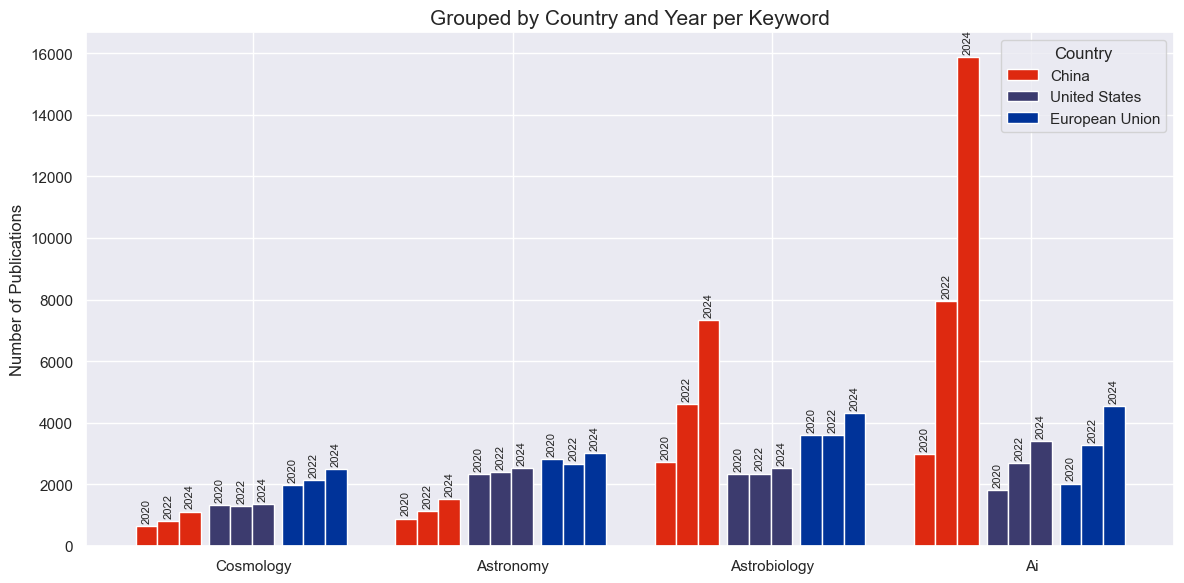

In [253]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_keyword_comparison_grouped(df, countries, keywords, years):
    df = df.dropna(subset=['grouped_keywords']).copy()
    df['grouped_keywords'] = df['grouped_keywords'].str.lower()
    df = df.assign(keyword_list=df['grouped_keywords'].str.split(','))
    df = df.explode('keyword_list')
    df['keyword_list'] = df['keyword_list'].str.strip()

    keywords = [kw.lower() for kw in keywords]
    years = sorted(years)

    df = df[df['keyword_list'].isin(keywords)]
    df = df[df['country_grouped'].isin(countries)]
    df = df[df['year'].isin(years)]

    # Count publications
    grouped = df.groupby(['keyword_list', 'country_grouped', 'year']).size().reset_index(name='count')
    pivot = grouped.pivot_table(index=['keyword_list', 'country_grouped', 'year'], values='count', fill_value=0)



    # Setup
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.08
    spacing_between_years = 0.00
    spacing_between_countries = 0.03
    spacing_between_keywords = 0.15
    colors = {
        "China": "#de2910",
        "United States": "#3c3b6e",
        "European Union": "#003399"
    }

    x = 0
    xtick_positions = []
    xtick_labels = []
    legend_handles = {}

    for keyword in keywords:
        for country in countries:
            for i, year in enumerate(years):
                value = pivot.loc[(keyword, country, year)] if (keyword, country, year) in pivot.index else 0
                xpos = x
                bar = ax.bar(xpos, value, width=bar_width, color=colors[country])
                if country not in legend_handles:
                    legend_handles[country] = bar[0]
                # Add year label above bar
                ax.text(xpos, value + 100, str(year), ha='center', va='bottom', fontsize=8, rotation=90)
                x += bar_width + spacing_between_years
            x += spacing_between_countries
        xtick_positions.append(x - (len(years) * (bar_width + spacing_between_years) + spacing_between_countries * len(countries) + 0.5) / 2)
        xtick_labels.append(keyword.capitalize())
        x += spacing_between_keywords

    # Final styling
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, fontsize=11)
    ax.set_ylabel("Number of Publications")
    ax.set_title("Grouped by Country and Year per Keyword", fontsize=15)
    ax.legend(legend_handles.values(), legend_handles.keys(), title="Country")
    plt.tight_layout()
    plt.show()



# Example run
plot_keyword_comparison_grouped(
    df=china_usa_eu,
    countries=["China", "United States", "European Union"],
    keywords=["Cosmology", "Astronomy", "Astrobiology", "AI",],
    years=[2020, 2022, 2024]
)



C:\Users\adbva\AppData\Local\Temp\ipykernel_18732\663306115.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




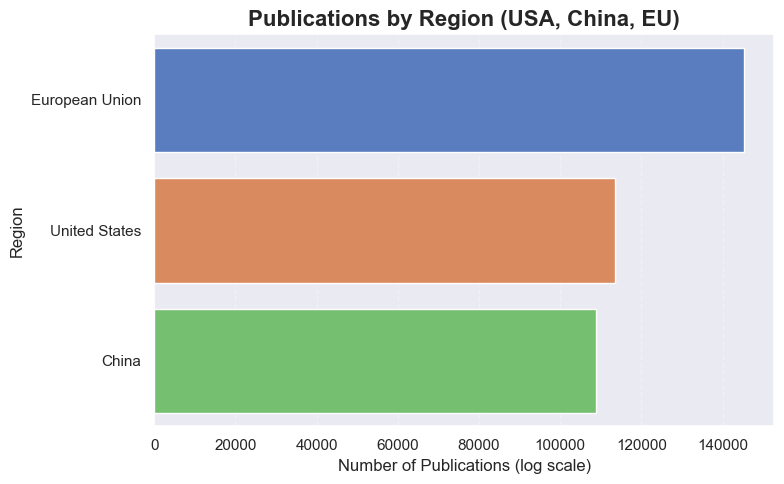

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

top3_counts = china_usa_eu["country_grouped"].value_counts().sort_values(ascending=False)

plt.style.use("dark_background")
sns.set_style("darkgrid")

plt.figure(figsize=(8, 5))
sns.barplot(x=top3_counts.values, y=top3_counts.index, palette="muted")
plt.title("Publications by Region (USA, China, EU)", fontsize=16, weight='bold')
plt.xlabel("Number of Publications (log scale)")
plt.ylabel("Region")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
